In [1]:
#install.packages("rlang")
#install.packages("caret")
#install.packages("dplyr")
#install.packages("gbm")
#install.packages("caret")
#install.packages("ggplot2")
#install.packages('pROC')

In [2]:
# Load libraries
library(dplyr)
library(caret)
library(readr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: lattice



In [3]:
# Load the dataset 'customer_churn'
Telecom_churn <- read.csv("customer_churn.csv")

### DATA DESCRIPTION

In [4]:
# Display the first few rows of the dataset
head(Telecom_churn)

,CustomerID,Age,Gender,Tenure,Usage.Frequency,Support.Calls,Payment.Delay,Subscription.Type,Contract.Length,Total.Spend,Last.Interaction,Churn
,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>
1,2,30,Female,39,14,5,18,Standard,Annual,932,17,1
2,3,65,Female,49,1,10,8,Basic,Monthly,557,6,1
3,4,55,Female,14,4,6,18,Basic,Quarterly,185,3,1
4,5,58,Male,38,21,7,7,Standard,Monthly,396,29,1
5,6,23,Male,32,20,5,8,Basic,Monthly,617,20,1
6,8,51,Male,33,25,9,26,Premium,Annual,129,8,1


In [5]:
# Display the last few rows of the dataset
tail(Telecom_churn)

,CustomerID,Age,Gender,Tenure,Usage.Frequency,Support.Calls,Payment.Delay,Subscription.Type,Contract.Length,Total.Spend,Last.Interaction,Churn
,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>
440828,449994,45,Male,6,25,2,15,Basic,Annual,837.00,2,0
440829,449995,42,Male,54,15,1,3,Premium,Annual,716.38,8,0
440830,449996,25,Female,8,13,1,20,Premium,Annual,745.38,2,0
440831,449997,26,Male,35,27,1,5,Standard,Quarterly,977.31,9,0
440832,449998,28,Male,55,14,2,0,Standard,Quarterly,602.55,2,0
440833,449999,31,Male,48,20,1,14,Premium,Quarterly,567.77,21,0


In [6]:
#Display the structure of the dataset
str(Telecom_churn)

'data.frame':	440833 obs. of  12 variables:
 $ CustomerID       : int  2 3 4 5 6 8 9 10 11 12 ...
 $ Age              : int  30 65 55 58 23 51 58 55 39 64 ...
 $ Gender           : chr  "Female" "Female" "Female" "Male" ...
 $ Tenure           : int  39 49 14 38 32 33 49 37 12 3 ...
 $ Usage.Frequency  : int  14 1 4 21 20 25 12 8 5 25 ...
 $ Support.Calls    : int  5 10 6 7 5 9 3 4 7 2 ...
 $ Payment.Delay    : int  18 8 18 7 8 26 16 15 4 11 ...
 $ Subscription.Type: chr  "Standard" "Basic" "Basic" "Standard" ...
 $ Contract.Length  : chr  "Annual" "Monthly" "Quarterly" "Monthly" ...
 $ Total.Spend      : num  932 557 185 396 617 129 821 445 969 415 ...
 $ Last.Interaction : int  17 6 3 29 20 8 24 30 13 29 ...
 $ Churn            : int  1 1 1 1 1 1 1 1 1 1 ...


In [7]:
#Check for the number of rows
nrow(Telecom_churn)

[1] 440833

In [8]:
#Check for the number of columns
ncol(Telecom_churn)

[1] 12

In [9]:
#Check for the names of columns
names(Telecom_churn)

[1] "CustomerID"        "Age"               "Gender"           
 [4] "Tenure"            "Usage.Frequency"   "Support.Calls"    
 [7] "Payment.Delay"     "Subscription.Type" "Contract.Length"  
[10] "Total.Spend"       "Last.Interaction"  "Churn"

In [10]:
# Display descriptive statistics
summary(Telecom_churn)

   CustomerID          Age           Gender              Tenure     
 Min.   :     2   Min.   :18.00   Length:440833      Min.   : 1.00  
 1st Qu.:113622   1st Qu.:29.00   Class :character   1st Qu.:16.00  
 Median :226126   Median :39.00   Mode  :character   Median :32.00  
 Mean   :225399   Mean   :39.37                      Mean   :31.26  
 3rd Qu.:337739   3rd Qu.:48.00                      3rd Qu.:46.00  
 Max.   :449999   Max.   :65.00                      Max.   :60.00  
 NA's   :1        NA's   :1                          NA's   :1      
 Usage.Frequency Support.Calls    Payment.Delay   Subscription.Type 
 Min.   : 1.00   Min.   : 0.000   Min.   : 0.00   Length:440833     
 1st Qu.: 9.00   1st Qu.: 1.000   1st Qu.: 6.00   Class :character  
 Median :16.00   Median : 3.000   Median :12.00   Mode  :character  
 Mean   :15.81   Mean   : 3.604   Mean   :12.97                     
 3rd Qu.:23.00   3rd Qu.: 6.000   3rd Qu.:19.00                     
 Max.   :30.00   Max.   :10.000   

### DATA PRE-PROCESSING

In [11]:
#Check for total number of missing values
sum(colSums(is.na(Telecom_churn)))

[1] 9

In [12]:
# Handling missing values by imputing with the median for numerical columns
numeric_columns <- sapply(Telecom_churn, is.numeric)
Telecom_churn[numeric_columns] <- lapply(Telecom_churn[numeric_columns], function(x) {
  ifelse(is.na(x), median(x, na.rm = TRUE), x)
})

In [13]:
#Check for total number of missing values
sum(colSums(is.na(Telecom_churn)))

[1] 0

In [14]:
Churn_summary<-table(Telecom_churn$Churn)
Churn_summary


     0      1 
190833 250000 

In [15]:
# Check for outliers using the IQR method
outliers <- sapply(Telecom_churn[numeric_columns], function(x) {
  q75 <- quantile(x, 0.75, na.rm = TRUE)
  q25 <- quantile(x, 0.25, na.rm = TRUE)
  iqr <- q75 - q25
  sum(x < (q25 - 1.5 * iqr) | x > (q75 + 1.5 * iqr))
})

# Display the number of outliers detected for each numeric column
outliers

CustomerID              Age           Tenure  Usage.Frequency 
               0                0                0                0 
   Support.Calls    Payment.Delay      Total.Spend Last.Interaction 
               0                0                0                0 
           Churn 
               0


     0      1 
190833 250000 

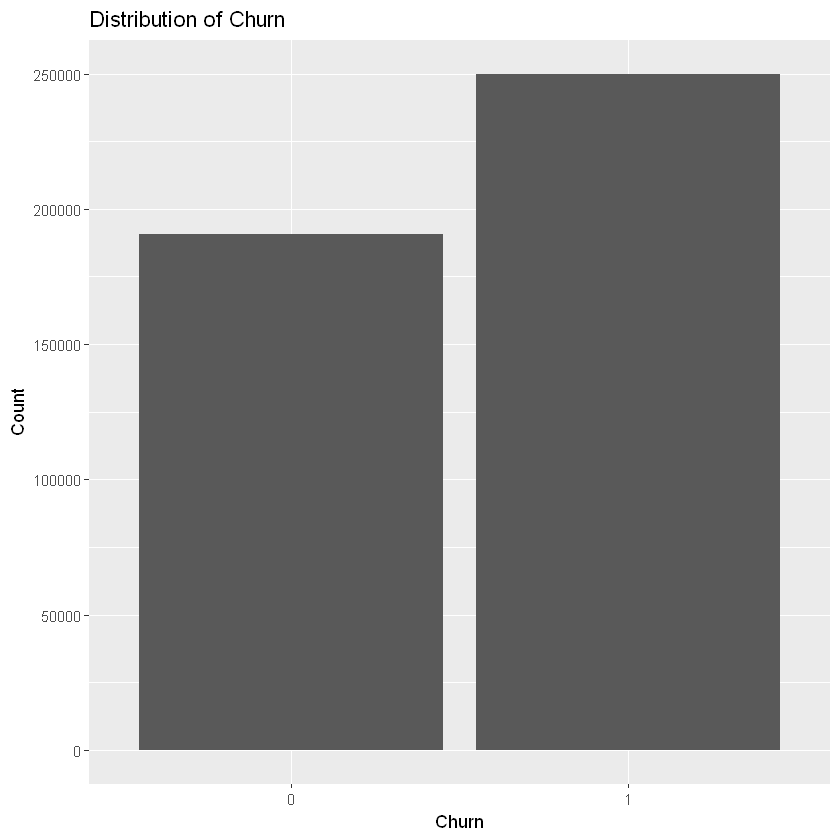

In [16]:
library(ggplot2)

# Plot the distribution of the target variable 'churn'
ggplot(Telecom_churn, aes(x = factor(Churn))) +
  geom_bar() +
  labs(x = 'Churn', y = 'Count') +
  ggtitle('Distribution of Churn')

# Summary of the target variable
Churn_summary <- table(Telecom_churn$Churn)
Churn_summary

In [17]:
# Label encoding using 'factor' function
Telecom_churn$Gender <- as.numeric(factor(Telecom_churn$Gender))
Telecom_churn$Subscription.Type <- as.numeric(factor(Telecom_churn$Subscription.Type))
Telecom_churn$Contract.Length <- as.numeric(factor(Telecom_churn$Contract.Length))


In [18]:
head(Telecom_churn)

,CustomerID,Age,Gender,Tenure,Usage.Frequency,Support.Calls,Payment.Delay,Subscription.Type,Contract.Length,Total.Spend,Last.Interaction,Churn
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,30,2,39,14,5,18,4,2,932,17,1
2,3,65,2,49,1,10,8,2,3,557,6,1
3,4,55,2,14,4,6,18,2,4,185,3,1
4,5,58,3,38,21,7,7,4,3,396,29,1
5,6,23,3,32,20,5,8,2,3,617,20,1
6,8,51,3,33,25,9,26,3,2,129,8,1


In [19]:
# Check for outliers using the IQR method
outliers <- sapply(Telecom_churn[numeric_columns], function(x) {
  q75 <- quantile(x, 0.75, na.rm = TRUE)
  q25 <- quantile(x, 0.25, na.rm = TRUE)
  iqr <- q75 - q25
  sum(x < (q25 - 1.5 * iqr) | x > (q75 + 1.5 * iqr))
})

# Display the number of outliers detected for each numeric column
outliers

CustomerID              Age           Tenure  Usage.Frequency 
               0                0                0                0 
   Support.Calls    Payment.Delay      Total.Spend Last.Interaction 
               0                0                0                0 
           Churn 
               0

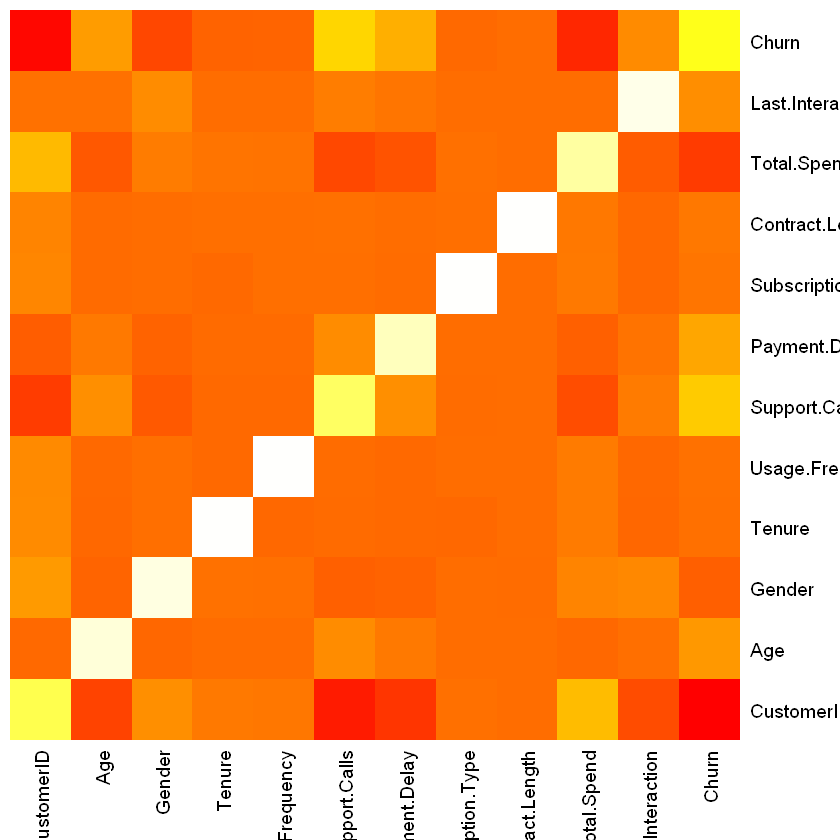

In [20]:
# Calculate the correlation matrix for between variables
numeric_vars <- Telecom_churn[, sapply(Telecom_churn, is.numeric)]
cor_matrix <- cor(numeric_vars)

# Visualize the correlation matrix using a heatmap
heatmap(cor_matrix, Rowv=NA, Colv=NA, col = heat.colors(256), scale="column", margins=c(5,5))

In [21]:
# Calculate the correlation of all predictors with the target variable'churn'
correlations <- cor(Telecom_churn[, sapply(Telecom_churn, is.numeric)])
correlation_with_target <- abs(correlations[,'Churn'])

# Sort features by their correlation with 'churn'
sorted_features <- sort(correlation_with_target, decreasing = TRUE)

# Display the sorted features
sorted_features

Churn        CustomerID     Support.Calls       Total.Spend 
     1.000000e+00      8.393644e-01      5.742662e-01      4.293542e-01 
    Payment.Delay               Age            Gender  Last.Interaction 
     3.121288e-01      2.183937e-01      1.753988e-01      1.496158e-01 
           Tenure   Usage.Frequency Subscription.Type   Contract.Length 
     5.191883e-02      4.610084e-02      1.718528e-02      9.730029e-05

In [22]:
# FEATURE SELECTION
library(dplyr)
library(caret)

# Feature Selection
Telecom_churn <- Telecom_churn %>% select(-CustomerID)


In [23]:
head(Telecom_churn)

,Age,Gender,Tenure,Usage.Frequency,Support.Calls,Payment.Delay,Subscription.Type,Contract.Length,Total.Spend,Last.Interaction,Churn
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,30,2,39,14,5,18,4,2,932,17,1
2,65,2,49,1,10,8,2,3,557,6,1
3,55,2,14,4,6,18,2,4,185,3,1
4,58,3,38,21,7,7,4,3,396,29,1
5,23,3,32,20,5,8,2,3,617,20,1
6,51,3,33,25,9,26,3,2,129,8,1


In [24]:
# Remove churn column from the dataset so it doesn't get normalized
sdataset <- subset(Telecom_churn,  select = -c(Churn) )

In [25]:
# Normalize numerical features
preproc <- preProcess(sdataset, method = c("center", "scale"))
Telecom_churn_normalized <- predict(preproc, sdataset)

In [26]:
summary(Telecom_churn_normalized)

      Age               Gender            Tenure        Usage.Frequency   
 Min.   :-1.71777   Min.   :-3.1644   Min.   :-1.7534   Min.   :-1.72456  
 1st Qu.:-0.83370   1st Qu.:-1.1459   1st Qu.:-0.8841   1st Qu.:-0.79284  
 Median :-0.02999   Median : 0.8727   Median : 0.0431   Median : 0.02242  
 Mean   : 0.00000   Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.00000  
 3rd Qu.: 0.69335   3rd Qu.: 0.8727   3rd Qu.: 0.8544   3rd Qu.: 0.83768  
 Max.   : 2.05965   Max.   : 0.8727   Max.   : 1.6657   Max.   : 1.65294  
 Support.Calls     Payment.Delay     Subscription.Type Contract.Length    
 Min.   :-1.1740   Min.   :-1.5701   Min.   :-2.474    Min.   :-2.231001  
 1st Qu.:-0.8483   1st Qu.:-0.8435   1st Qu.:-1.246    1st Qu.:-1.114652  
 Median :-0.1969   Median :-0.1169   Median :-0.017    Median : 0.001697  
 Mean   : 0.0000   Mean   : 0.0000   Mean   : 0.000    Mean   : 0.000000  
 3rd Qu.: 0.7803   3rd Qu.: 0.7307   3rd Qu.: 1.212    3rd Qu.: 1.118046  
 Max.   : 2.0831   Max.  

In [27]:
# Add the churn column back to the dataset
Telecom_churn_normalized$churn<-Telecom_churn$Churn

In [28]:
churn_summary <- table(Telecom_churn_normalized$churn)
churn_summary


     0      1 
190833 250000 

In [29]:
Telecom_churn_final <- Telecom_churn_normalized

In [30]:
head(Telecom_churn_final)

,Age,Gender,Tenure,Usage.Frequency,Support.Calls,Payment.Delay,Subscription.Type,Contract.Length,Total.Spend,Last.Interaction,churn
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.7533262,-1.1458888,0.44875948,-0.2105107,0.4545496,0.6096207,1.21154325,-1.114652365,1.24742651,0.2930520,1
2,2.0596460,-1.1458888,1.02827787,-1.7245625,2.0831003,-0.6013184,-1.24554303,0.001696683,-0.30986480,-0.9865835,1
3,1.2559396,-1.1458888,-1.00003649,-1.3751660,0.7802597,0.6096207,-1.24554303,1.118045731,-1.85469777,-1.3355750,1
4,1.4970515,0.8726669,0.39080765,0.6047479,1.1059699,-0.7224123,1.21154325,0.001696683,-0.97846186,1.6890180,1
5,-1.3159207,0.8726669,0.04309661,0.4882824,0.4545496,-0.6013184,-1.24554303,0.001696683,-0.06069819,0.6420435,1
6,0.9344571,0.8726669,0.10104845,1.0706100,1.7573901,1.5783721,-0.01699989,-1.114652365,-2.08725327,-0.7539225,1


In [31]:
# Ensure 'Churn' is a factor with two levels: 0 and 1
Telecom_churn_final$churn <- factor(Telecom_churn_final$churn, levels = c(0, 1))

### MODEL BUILDING

In [32]:
# Split the data into training and testing sets
set.seed(123)
trainIndex <- createDataPartition(Telecom_churn_final$churn, p = .7, list = FALSE, times = 1)
data_train <- Telecom_churn_final[trainIndex, ]
data_test <- Telecom_churn_final[-trainIndex, ]

list(data_train = dim(data_train), data_test = dim(data_test))

$data_train
[1] 308584     11

$data_test
[1] 132249     11

In [33]:
train_summary <- table(data_train$churn)
train_summary


     0      1 
133584 175000 

In [34]:
colnames(data_train)

[1] "Age"               "Gender"            "Tenure"           
 [4] "Usage.Frequency"   "Support.Calls"     "Payment.Delay"    
 [7] "Subscription.Type" "Contract.Length"   "Total.Spend"      
[10] "Last.Interaction"  "churn"

In [35]:
colnames(data_test)

[1] "Age"               "Gender"            "Tenure"           
 [4] "Usage.Frequency"   "Support.Calls"     "Payment.Delay"    
 [7] "Subscription.Type" "Contract.Length"   "Total.Spend"      
[10] "Last.Interaction"  "churn"

In [36]:
table(data_train$churn)


     0      1 
133584 175000 

In [37]:
# Logistic Regression
# Load necessary libraries
library(caret)
library(stats)

# logistic regression model
LogisticRegression_model <- caret::train(
  churn ~ .,
  data = data_train,
  method = 'glm',
  family = 'binomial',
  trControl = caret::trainControl(method = "none"),
  tuneLength = 1  # Since glm doesn't require tuning, set tuneLength to 1
)

# Check the model output
print(LogisticRegression_model)

Generalized Linear Model 

308584 samples
    10 predictor
     2 classes: '0', '1' 

No pre-processing
Resampling: None 


In [38]:
# Load the necessary libraries
library(gbm)
library(caret)

# Set up training control
train_control <- trainControl(method = "cv", number = 10, verboseIter = FALSE)  # 10-fold cross-validation

# Train the gradient boosting model
GradientBoosting_model <- train(
  churn ~ .,
  data = data_train,
  method = 'gbm',
  trControl = train_control,
  verbose = FALSE
)

# Check the model output
print(GradientBoosting_model)

Loaded gbm 2.1.9

This version of gbm is no longer under development. Consider transitioning to gbm3, https://github.com/gbm-developers/gbm3



Stochastic Gradient Boosting 

308584 samples
    10 predictor
     2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 277726, 277726, 277726, 277725, 277725, 277726, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  Accuracy   Kappa    
  1                   50      0.9520584  0.9034675
  1                  100      0.9528524  0.9050457
  1                  150      0.9567800  0.9128633
  2                   50      0.9602669  0.9198182
  2                  100      0.9878510  0.9752992
  2                  150      0.9927605  0.9852838
  3                   50      0.9657792  0.9308386
  3                  100      0.9925596  0.9848740
  3                  150      0.9944910  0.9887969

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held constant at a value of 10
Accuracy was used to select the optimal model using the largest value.
The final va

### MODEL EVALUATION

In [39]:
# Load necessary library
library(caret)

# Predict on testing data using the logistic regression model
logistic_predictions <- predict(LogisticRegression_model, newdata = data_test, type = "prob")

#we select the probabilities of the positive class
logistic_predicted_probabilities <- logistic_predictions[,2]

# Convert these probabilities to binary outcome (0 or 1) based on a threshold, usually 0.5
logistic_predicted_classes <- ifelse(logistic_predicted_probabilities > 0.5, 1, 0)

# Ensure 'churn' variable in testing_data to a factor with two levels
data_test$churn <- factor(data_test$churn, levels = c(0, 1))

# Convert the predicted classes to a factor with the same levels as the actual outcomes
logistic_predicted_classes <- factor(logistic_predicted_classes, levels = c(0, 1))

# Evaluate the model
  logistic_results <- confusionMatrix(logistic_predicted_classes, data_test$churn)
  #print(logistic_results)

In [48]:
# Print Logistic Regression metrics
print(logistic_results)
print(paste("Accuracy:", logistic_results$overall['Accuracy']))
print(paste("Precision:", logistic_results$byClass['Precision']))
print(paste("Recall:", logistic_results$byClass['Recall']))
print(paste("F1 Score:", logistic_results$byClass['F1']))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 48624 11020
         1  8625 63980
                                          
               Accuracy : 0.8515          
                 95% CI : (0.8495, 0.8534)
    No Information Rate : 0.5671          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6989          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.8493          
            Specificity : 0.8531          
         Pos Pred Value : 0.8152          
         Neg Pred Value : 0.8812          
             Prevalence : 0.4329          
         Detection Rate : 0.3677          
   Detection Prevalence : 0.4510          
      Balanced Accuracy : 0.8512          
                                          
       'Positive' Class : 0               
                  

Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Setting levels: control = 0, case = 1

Setting direction: controls < cases



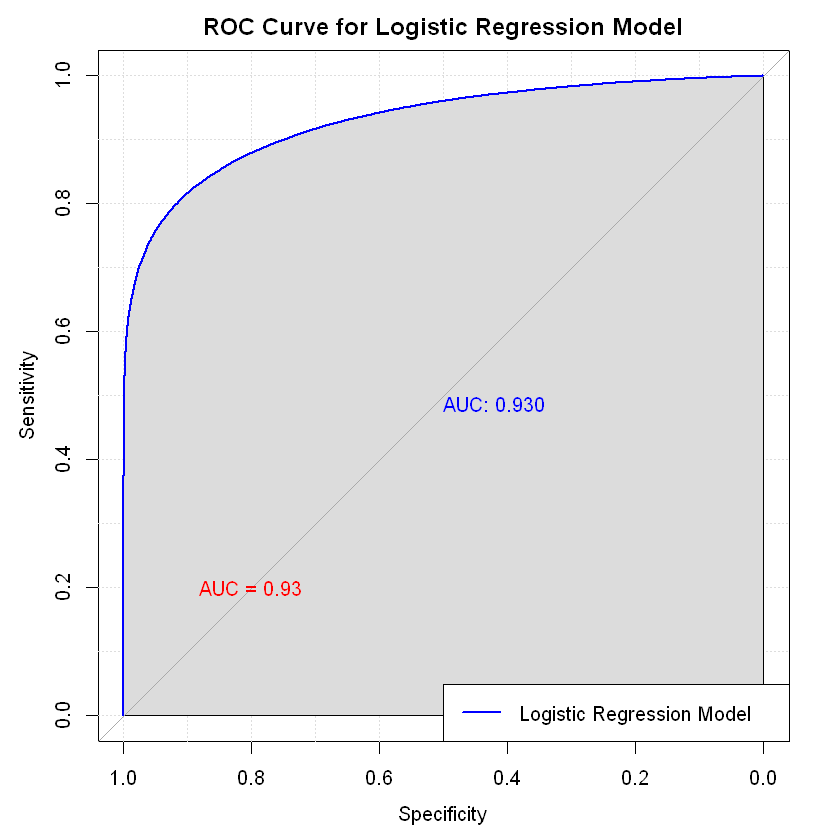

In [41]:
# Load necessary library for ROC curve and AUC calculation
library(pROC)

# Create ROC curve object
roc_curve <- roc(as.numeric(data_test$churn) - 1, logistic_predicted_probabilities)

# Calculate AUC
auc_score <- auc(roc_curve)

# Plot ROC curve
plot(roc_curve, main = "ROC Curve for Logistic Regression Model",
     col = "blue", lwd = 2,
     print.auc = TRUE, auc.polygon = TRUE,
     grid = TRUE)

# Add AUC value to the plot
text(0.8, 0.2, paste("AUC =", round(auc_score, 2)), col = "red")

# Add legend
legend("bottomright", legend = c("Logistic Regression Model"), col = c("blue"), lwd = 2)

In [42]:
library(caret)
library(gbm)

# Make predictions on the test set using the trained model
predictions <- predict(GradientBoosting_model, newdata = data_test, type = "prob")

predicted_classes <- ifelse(predictions[, "1"] > 0.5, 1, 0) # '1' is the class for churn

# Actual values of Churn from the test set
actual_classes <- data_test$churn

# Confusion Matrix to evaluate the model
XGBoost_results <- confusionMatrix(as.factor(predicted_classes), as.factor(actual_classes))

# Print the confusion matrix
#print(XGBoost_results)

In [49]:
# Print XGBoost metrics
print(XGBoost_results)
print(paste("Accuracy:", XGBoost_results$overall['Accuracy']))
print(paste("Precision:", XGBoost_results$byClass['Precision']))
print(paste("Recall:", XGBoost_results$byClass['Recall']))
print(paste("F1 Score:", XGBoost_results$byClass['F1']))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 57248   882
         1     1 74118
                                          
               Accuracy : 0.9933          
                 95% CI : (0.9929, 0.9938)
    No Information Rate : 0.5671          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9864          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 1.0000          
            Specificity : 0.9882          
         Pos Pred Value : 0.9848          
         Neg Pred Value : 1.0000          
             Prevalence : 0.4329          
         Detection Rate : 0.4329          
   Detection Prevalence : 0.4395          
      Balanced Accuracy : 0.9941          
                                          
       'Positive' Class : 0               
                  

Setting levels: control = 0, case = 1

Setting direction: controls < cases



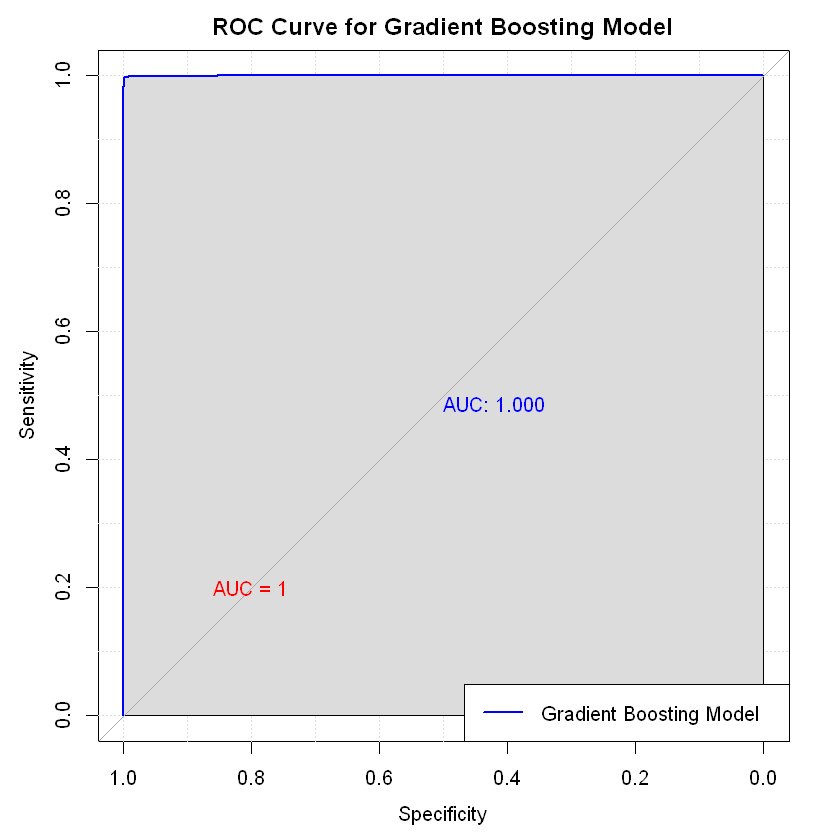

In [44]:
library(pROC)

# Extract predicted probabilities for class 1
predicted_probabilities <- predictions[, "1"]

# Create ROC curve object
roc_curve_gbm <- roc(as.numeric(actual_classes) - 1, predicted_probabilities)

# Calculate AUC
auc_score_gbm <- auc(roc_curve_gbm)

# Plot ROC curve
plot(roc_curve_gbm, main = "ROC Curve for Gradient Boosting Model",
     col = "blue", lwd = 2,
     print.auc = TRUE, auc.polygon = TRUE,
     grid = TRUE)

# Add AUC value to the plot
text(0.8, 0.2, paste("AUC =", round(auc_score_gbm, 2)), col = "red")

# Add legend
legend("bottomright", legend = c("Gradient Boosting Model"), col = c("blue"), lwd = 2)